<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Model Classes

The model classes represent the fundamental building blocks to model a financial market. They are used to represent the fundamental risk factors driving uncertainty (e.g. a stock, an equity index an interest rate). The following models are available:

* `geometric_brownian_motion`: Black-Scholes-Merton (1973) geometric Brownian motion
* `jump_diffusion`: Merton (1976) jump diffusion
* `stochastic_volatility`: Heston (1993) stochastic volatility model
* `stoch_vol_jump_diffusion`: Bates (1996) stochastic volatility jump diffusion
* `sabr_stochastic_volatility`: Hagan et al. (2002) stochastic volatility model
* `mean_reverting_diffusion`: Vasicek (1977) short rate model
* `square_root_diffusion`: Cox-Ingersoll-Ross (1985) square-root diffusion
* `square_root_jump_diffusion`: square-root jump diffusion (experimental)
* `square_root_jump_diffusion_plus`: square-root jump diffusion plus term structure (experimental)

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
from dx import *
import seaborn as sns; sns.set()

In [3]:
np.set_printoptions(precision=3)

Throughout this section we fix a `constant_short_rate` discounting object.

In [4]:
r = constant_short_rate('r', 0.06)

## geometric_brownian_motion

To instantiate any kind of model class, you need a `market_environment` object conataining a minimum set of data (depending on the specific model class).

In [5]:
me = market_environment(name='me', pricing_date=dt.datetime(2015, 1, 1))

For the **geometric Browniam motion class**, the minimum set is as follows with regard to the constant parameter values. Here, we simply make assumptions, in practice the single values would, for example be retrieved from a data service provider like Thomson Reuters or Bloomberg. The frequency parameter is according to the pandas frequency conventions (cf. <a href="http://pandas.pydata.org/pandas-docs/stable/timeseries.html" target="_blank">http://pandas.pydata.org/pandas-docs/stable/timeseries.html</a>).

In [6]:
me.add_constant('initial_value', 36.)
me.add_constant('volatility', 0.2)
me.add_constant('final_date', dt.datetime(2015, 12, 31))
  # time horizon for the simulation
me.add_constant('currency', 'EUR')
me.add_constant('frequency', 'M')
  # monthly frequency; paramter accorind to pandas convention
me.add_constant('paths', 1000)
  # number of paths for simulation

Every model class needs a discounting object since this defines the risk-neutral drift of the risk factor.

In [7]:
me.add_curve('discount_curve', r)

The instantiation of a model class is then accomplished by providing a name as a `string` object and the respective `market_environment` object.

In [8]:
gbm = geometric_brownian_motion('gbm', me)

The `generate_time_grid` method generates a `ndarray` objet of `datetime` objects given the specifications in the market environment. This represents the discretization of the time interval between the `pricing_date` and the `final_date`. This method does not need to be called actively.

In [9]:
gbm.generate_time_grid()

In [10]:
gbm.time_grid

array([datetime.datetime(2015, 1, 1, 0, 0),
       datetime.datetime(2015, 1, 31, 0, 0),
       datetime.datetime(2015, 2, 28, 0, 0),
       datetime.datetime(2015, 3, 31, 0, 0),
       datetime.datetime(2015, 4, 30, 0, 0),
       datetime.datetime(2015, 5, 31, 0, 0),
       datetime.datetime(2015, 6, 30, 0, 0),
       datetime.datetime(2015, 7, 31, 0, 0),
       datetime.datetime(2015, 8, 31, 0, 0),
       datetime.datetime(2015, 9, 30, 0, 0),
       datetime.datetime(2015, 10, 31, 0, 0),
       datetime.datetime(2015, 11, 30, 0, 0),
       datetime.datetime(2015, 12, 31, 0, 0)], dtype=object)

The simulation itself is initiated by a call of the method `get_instrument_values`. It returns an `ndarray` object containing the simulated paths for the risk factor.

In [11]:
paths = gbm.get_instrument_values()

In [12]:
paths[:, :2]

array([[ 36.   ,  36.   ],
       [ 35.819,  39.084],
       [ 35.857,  36.918],
       [ 35.808,  40.226],
       [ 36.941,  39.883],
       [ 35.171,  43.389],
       [ 38.559,  44.775],
       [ 37.54 ,  43.593],
       [ 37.977,  39.925],
       [ 36.249,  38.091],
       [ 37.665,  40.338],
       [ 36.593,  39.91 ],
       [ 36.716,  41.727]])

These can, for instance, be visualized easily. First some plotting parameter specifications we want to use throughout.

In [13]:
%matplotlib inline
colormap='RdYlBu_r'
lw=1.25
figsize=(10, 6)
legend=False
no_paths=10

For easy plotting, we put the data with the `time_grid` information into a pandas `DataFrame` object.

In [14]:
pdf = pd.DataFrame(paths, index=gbm.time_grid)

The following visualizes the first 10 paths of the simulation.

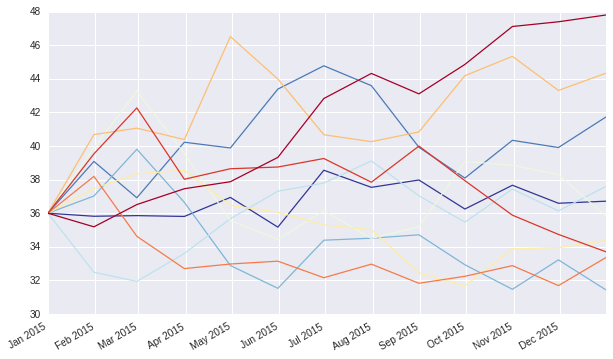

In [15]:
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

## jump_diffusion

The next model is the **jump diffusion model from Merton (1976)** adding a log-normally distributed jump component to the geometric Brownian motion. Three more parameter values are needed:

In [16]:
me.add_constant('lambda', 0.7)
  # probability for a jump p.a.
me.add_constant('mu', -0.8)
  # expected relative jump size
me.add_constant('delta', 0.1)
  # standard deviation of relative jump

The instantiation of the model class and usage then is the same as before.

In [17]:
jd = jump_diffusion('jd', me)

In [18]:
paths = jd.get_instrument_values()

In [19]:
pdf = pd.DataFrame(paths, index=jd.time_grid)

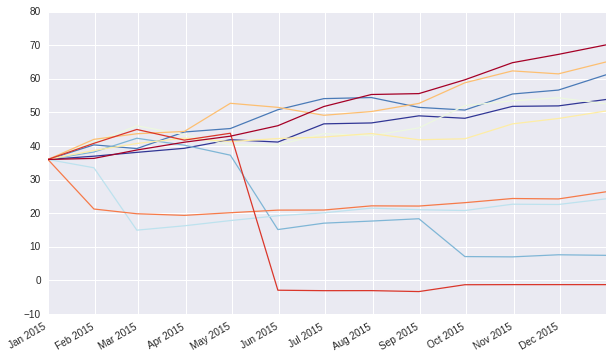

In [20]:
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

## stochastic_volatility

Another important financial model is the  **stochastic volatility model according to Heston (1993)**. Compared to the geometric Brownian motion, this model class need four more parameter values.

In [21]:
me.add_constant('rho', -.5)
  # correlation between risk factor process (eg index)
  # and variance process 
me.add_constant('kappa', 2.5)
  # mean reversion factor
me.add_constant('theta', 0.1)
  # long-term variance level
me.add_constant('vol_vol', 0.1)
  # volatility factor for variance process

Again, the instantiation and usage of this model class are essentially the same.

In [22]:
sv = stochastic_volatility('sv', me)

The following visualizes 10 simulated paths for the **risk factor process**.

In [23]:
paths = sv.get_instrument_values()

In [24]:
pdf = pd.DataFrame(paths, index=sv.time_grid)

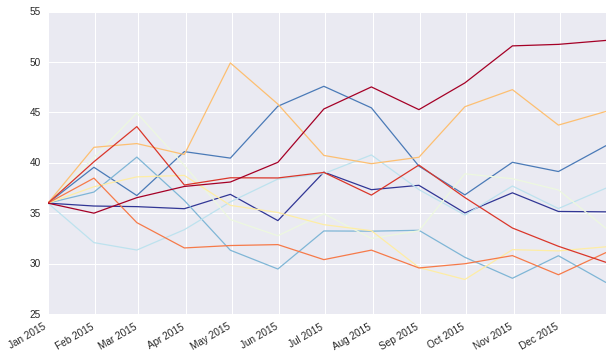

In [25]:
# index level paths
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

This model class has a second set of simulated paths, namely for the **variance process**.

In [26]:
vols = sv.get_volatility_values()

In [27]:
pdf = pd.DataFrame(vols, index=sv.time_grid)

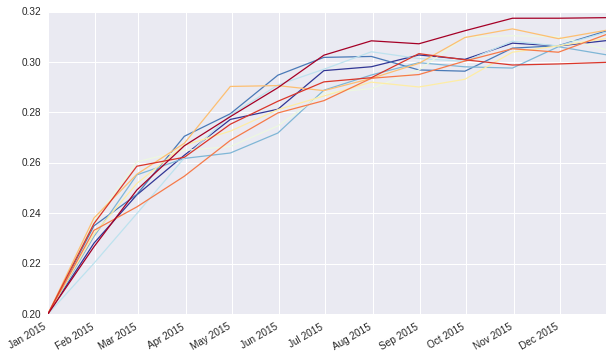

In [28]:
# volatility paths
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

## stoch_vol_jump_diffusion

The next model class, i.e. `stoch_vol_jump_diffusion`, combines **stochastic volatility with a jump diffusion according to Bates (1996).** Our market environment object `me` contains already all parameters needed for the instantiation of this model.

In [29]:
svjd = stoch_vol_jump_diffusion('svjd', me)

As with the `stochastic_volatility` class, this class generates simulated paths for both the **risk factor and variance process**.

In [30]:
paths = svjd.get_instrument_values()

In [31]:
pdf = pd.DataFrame(paths, index=svjd.time_grid)

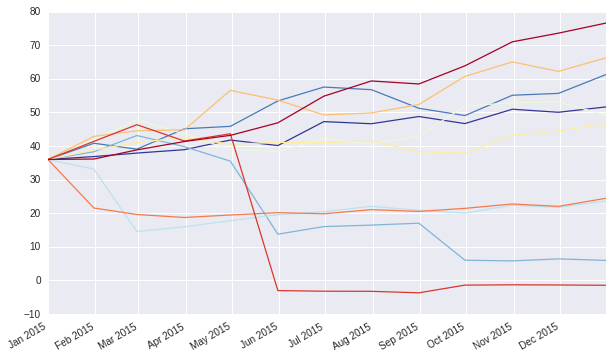

In [32]:
# index level paths
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

In [33]:
vols = svjd.get_volatility_values()

In [34]:
pdf = pd.DataFrame(vols, index=svjd.time_grid)

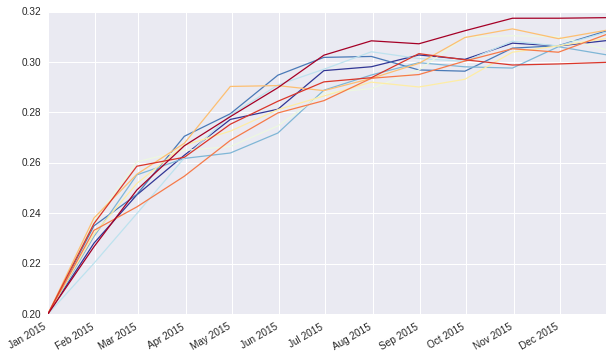

In [35]:
# volatility paths
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

## sabr_stochastic_volatility

The `sabr_stochastic_volatility` model is based on the **Hagan et al. (2002)** paper. It needs the following parameters:

In [36]:
# short rate like parameters
me.add_constant('initial_value', 0.5)
  # starting value (eg inital short rate)
me.add_constant('alpha', 0.04)
  # initial variance
me.add_constant('beta', 0.5)
  # exponent
me.add_constant('rho', 0.1)
  # correlation factor
me.add_constant('vol_vol', 0.5)
  # volatility of volatility/variance

In [37]:
sabr = sabr_stochastic_volatility('sabr', me)

In [38]:
paths = sabr.get_instrument_values()

In [39]:
pdf = pd.DataFrame(paths, index=sabr.time_grid)

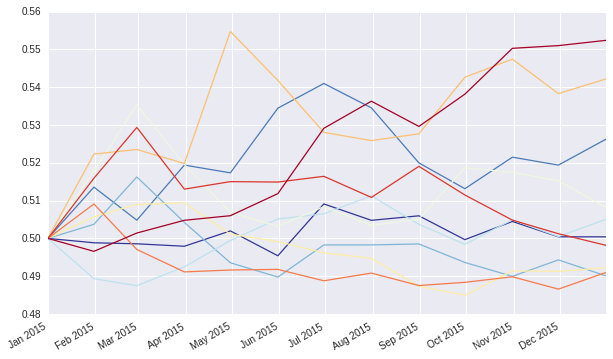

In [40]:
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

In [41]:
vols = sabr.get_volatility_values()

In [42]:
pdf = pd.DataFrame(vols, index=sabr.time_grid)

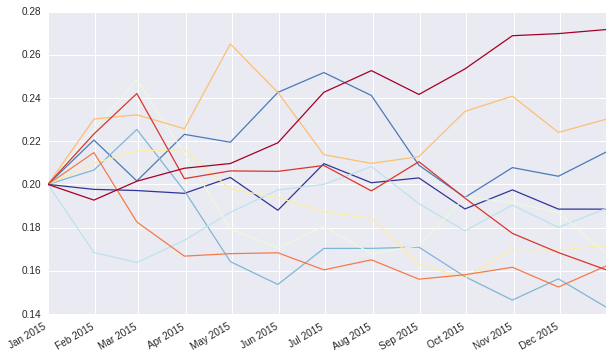

In [43]:
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

## mean_reverting_diffusion

The `mean_reverting_diffusion` model class is based on the **Vasicek (1977)** short rate model. It is suited to model mean-reverting quantities, like short rates, volatilities, etc. The model needs the following set of parameters:

In [44]:
# short rate like parameters
me.add_constant('initial_value', 0.05)
  # starting value (eg inital short rate)
me.add_constant('volatility', 0.05)
  # volatility factor
me.add_constant('kappa', 2.5)
  # mean reversion factor
me.add_constant('theta', 0.01)
  # long-term mean

In [45]:
mrd = mean_reverting_diffusion('mrd', me)

In [46]:
paths = mrd.get_instrument_values()

In [47]:
pdf_1 = pd.DataFrame(paths, index=mrd.time_grid)

Simulated paths can go negative which might be undesireable, e.g. when modeling volatility processes.

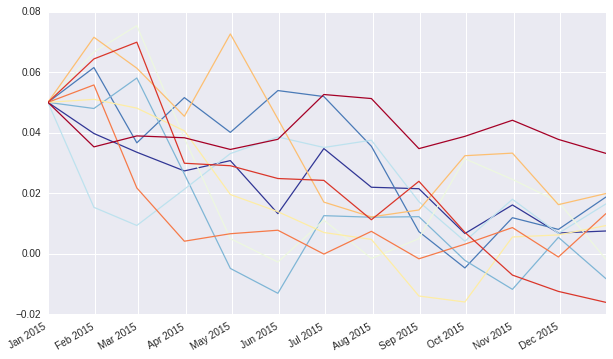

In [48]:
pdf_1[pdf_1.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

Using a full trunctation discretization scheme ensures positive paths.

In [49]:
mrd = mean_reverting_diffusion('mrd', me, truncation=True)
paths = mrd.get_instrument_values()
pdf_1 = pd.DataFrame(paths, index=mrd.time_grid)

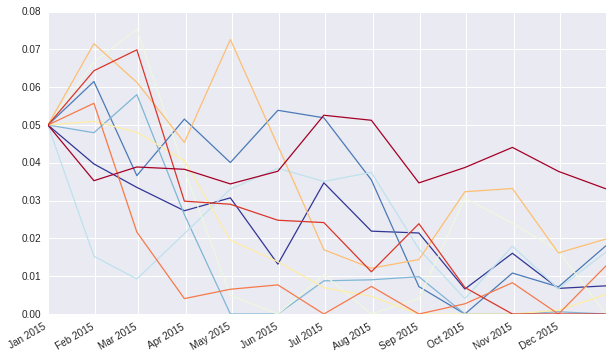

In [50]:
pdf_1[pdf_1.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

## square_root_diffusion

The `square_root_diffusion` model class is based on the **square-root diffusion according to Cox-Ingersoll-Ross (1985)**. This class is often used to model stochastic short rates or a volatility process (eg like the VSTOXX volatility index). The model needs the same parameters as the `mean_reverting_diffusion`.

As before, the handling of the model class is the same, making it easy to simulate paths given the parameter specifications and visualize them.

In [51]:
srd = square_root_diffusion('srd', me)

In [52]:
paths = srd.get_instrument_values()

In [53]:
pdf_2 = pd.DataFrame(paths, index=srd.time_grid)

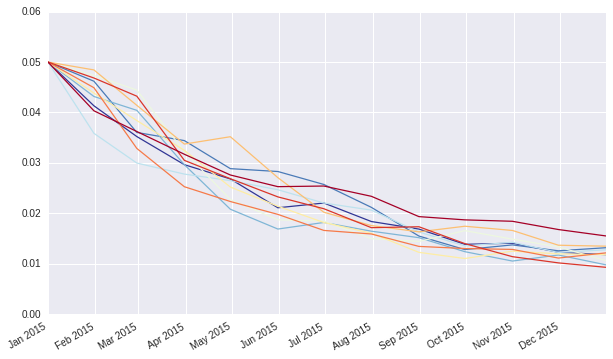

In [54]:
pdf_2[pdf_2.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

Let us compare the simulated paths --- based on the same parameters --- for the `mean_reverting_diffusion` and the `square_root_diffusion` in a single chart. The paths from the `mean_reverting_diffusion` object are much more volatile.

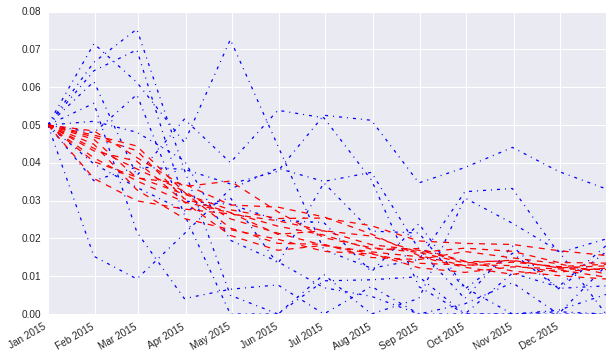

In [55]:
ax = pdf_1[pdf_1.columns[:no_paths]].plot(style='b-.', lw=lw,
                           figsize=figsize, legend=legend);
pdf_2[pdf_1.columns[:no_paths]].plot(style='r--', lw=lw,
                           figsize=figsize, legend=legend, ax=ax);

However, the *mean values* do not differ that much since both share the same long-term mean level. Mean reversion is faster with the `square_root_diffusion` model.

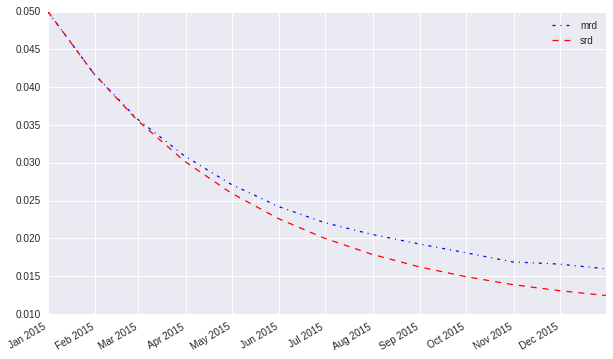

In [56]:
ax = pdf_1.mean(axis=1).plot(style='b-.', lw=lw,
                    figsize=figsize, label='mrd', legend=True);
pdf_2.mean(axis=1).plot(style='r--', lw=lw,
                    figsize=figsize, label='srd', legend=True);

## square_root_jump_diffusion

*Experimental Status*

Building on the square-root diffusion, there is a **square-root jump diffusion** adding a log-normally distributed jump component. The following parmeters might be for a volatility index, for example. In this case, the major risk might be a large positive jump in the index. The following model parameters are needed:

In [57]:
# volatility index like parameters
me.add_constant('initial_value', 25.)
  # starting values
me.add_constant('kappa', 2.)
  # mean-reversion factor
me.add_constant('theta', 20.)
  # long-term mean
me.add_constant('volatility', 1.)
  # volatility of diffusion
me.add_constant('lambda', 0.3)
  # probability for jump p.a.
me.add_constant('mu', 0.4)
  # expected jump size
me.add_constant('delta', 0.2)
  # standard deviation of jump

Once the `square_root_jump_diffusion` class is instantiated, the handling of the resulting object is the same as with the other model classes.

In [58]:
srjd = square_root_jump_diffusion('srjd', me)

In [59]:
paths = srjd.get_instrument_values()

In [60]:
pdf = pd.DataFrame(paths, index=srjd.time_grid)

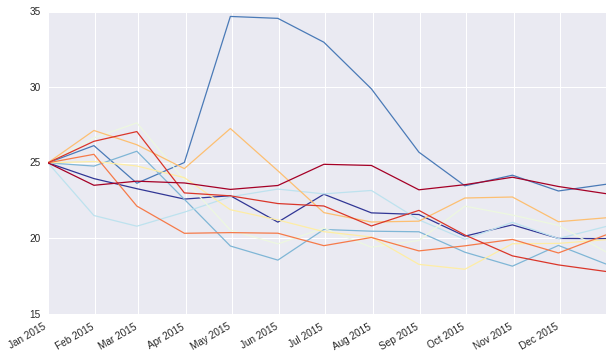

In [61]:
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

In [62]:
paths[-1].mean()

21.93069902310944

## square_root_jump_diffusion_plus

*Experimental Status*

This model class further enhances the `square_root_jump_diffusion` class by adding a **deterministic shift approach according to Brigo-Mercurio (2001)** to account for a market given term structure (e.g. in volatility, interest rates). Let us define a simple term structure as follows:

In [63]:
term_structure = np.array([(dt.datetime(2015, 1, 1), 25.),
                  (dt.datetime(2015, 3, 31), 24.),
                  (dt.datetime(2015, 6, 30), 27.),
                  (dt.datetime(2015, 9, 30), 28.),
                  (dt.datetime(2015, 12, 31), 30.)])

In [64]:
me.add_curve('term_structure', term_structure)

In [65]:
srjdp = square_root_jump_diffusion_plus('srjdp', me)

The method `generate_shift_base` calibrates the square-root diffusion to the given term structure (varying the parameters `kappa`, `theta` and `volatility`). 

In [66]:
srjdp.generate_shift_base((2.0, 20., 0.1))

Optimization terminated successfully.
         Current function value: 1.117824
         Iterations: 229
         Function evaluations: 431


The results are `shift_base` values, i.e. the difference between the model and market implied foward rates.

In [67]:
srjdp.shift_base
  # difference between market and model
  # forward rates after calibration

array([[datetime.datetime(2015, 1, 1, 0, 0), 0.0],
       [datetime.datetime(2015, 3, 31, 0, 0), -2.139861715691705],
       [datetime.datetime(2015, 6, 30, 0, 0), -0.19434592701965414],
       [datetime.datetime(2015, 9, 30, 0, 0), -0.157275574314653],
       [datetime.datetime(2015, 12, 31, 0, 0), 0.9734498133023948]], dtype=object)

The method `update_shift_values` then calculates deterministic shift values for the relevant time grid by interpolation of the `shift_base` values.

In [68]:
srjdp.update_shift_values()

In [69]:
srjdp.shift_values
  # shift values to apply to simulation scheme
  # given the shift base values

array([[datetime.datetime(2015, 1, 1, 0, 0), 0.0],
       [datetime.datetime(2015, 1, 31, 0, 0), -0.72130170191855247],
       [datetime.datetime(2015, 2, 28, 0, 0), -1.3945166237092015],
       [datetime.datetime(2015, 3, 31, 0, 0), -2.1398617156917048],
       [datetime.datetime(2015, 4, 30, 0, 0), -1.4984828842613584],
       [datetime.datetime(2015, 5, 31, 0, 0), -0.8357247584500006],
       [datetime.datetime(2015, 6, 30, 0, 0), -0.19434592701965414],
       [datetime.datetime(2015, 7, 31, 0, 0), -0.18185482991253418],
       [datetime.datetime(2015, 8, 31, 0, 0), -0.16936373280541422],
       [datetime.datetime(2015, 9, 30, 0, 0), -0.157275574314653],
       [datetime.datetime(2015, 10, 31, 0, 0), 0.22372971933891742],
       [datetime.datetime(2015, 11, 30, 0, 0), 0.59244451964882439],
       [datetime.datetime(2015, 12, 31, 0, 0), 0.97344981330239477]], dtype=object)

When simulating the process, the model forward rates ...

In [70]:
srjdp.update_forward_rates()
srjdp.forward_rates
  # model forward rates resulting from parameters

array([[datetime.datetime(2015, 1, 1, 0, 0), 25.0],
       [datetime.datetime(2015, 1, 31, 0, 0), 22.65694757330202],
       [datetime.datetime(2015, 2, 28, 0, 0), 20.700760393345639],
       [datetime.datetime(2015, 3, 31, 0, 0), 18.797095034394516],
       [datetime.datetime(2015, 4, 30, 0, 0), 17.206256506214984],
       [datetime.datetime(2015, 5, 31, 0, 0), 15.802066864566269],
       [datetime.datetime(2015, 6, 30, 0, 0), 14.651607085467674],
       [datetime.datetime(2015, 7, 31, 0, 0), 13.652189090303105],
       [datetime.datetime(2015, 8, 31, 0, 0), 12.819382165050907],
       [datetime.datetime(2015, 9, 30, 0, 0), 12.149056828894659],
       [datetime.datetime(2015, 10, 31, 0, 0), 11.575039304260786],
       [datetime.datetime(2015, 11, 30, 0, 0), 11.116201461381866],
       [datetime.datetime(2015, 12, 31, 0, 0), 10.725486593397667]], dtype=object)

... are then shifted by the `shift_values` to better match the term structure.

In [71]:
srjdp.forward_rates[:, 1] + srjdp.shift_values[:, 1]
  # shifted foward rates

array([25.0, 21.935645871383468, 19.306243769636438, 16.657233318702811,
       15.707773621953626, 14.966342106116269, 14.45726115844802,
       13.470334260390571, 12.650018432245494, 11.991781254580006,
       11.798769023599704, 11.70864598103069, 11.698936406700062], dtype=object)

The simulated paths then are including the deterministic shift.

In [72]:
paths = srjdp.get_instrument_values()

In [73]:
pdf = pd.DataFrame(paths, index=srjdp.time_grid)

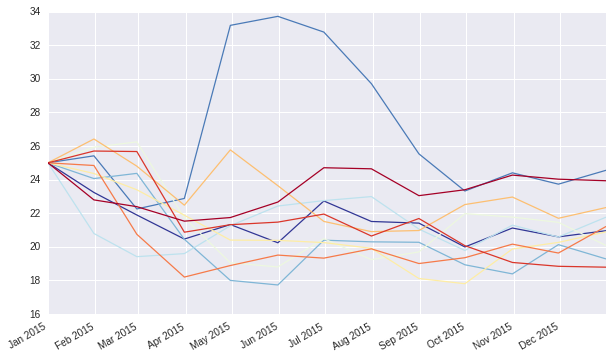

In [74]:
pdf[pdf.columns[:no_paths]].plot(colormap=colormap, lw=lw,
                           figsize=figsize, legend=legend);

The effect might not be immediately visible in the paths plot, however, the mean of the simulated values in this case is higher by about 1 point compared to the `square_root_jump_diffusion` simulation without deterministic shift.

In [75]:
paths[-1].mean()

22.904148836411835

**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)